# Реализовать задачу расчета площади методом Монте-Карло с использованием Numba

## а) с использованием только CPU

In [3]:
import numpy as np
import numba
from numba import njit
from numba import float32, int32

a = 1.0
b = 2.0
n = [100, 1000, 10000, 100000, 1000000]

In [2]:
@njit(float32(int32, float32, float32))
def monte_carlo(n, a, b):

  X_sequence = np.linspace(a, b, 1001)
  Y_sequence = np.array([x * x / (x + 1) + 1 / x for x in X_sequence])
  max_fx_value = Y_sequence.max()

  rect_area = max_fx_value * (b - a)

  X = np.random.uniform(a, b, n)
  Y = np.random.uniform(0, max_fx_value, n)

  fx_values = np.array([x * x / (x + 1) + 1 / x for x in X])
  under_curve = Y[Y<=fx_values].shape[0]

  S = rect_area * (under_curve / n)
  return S;

In [3]:
%timeit monte_carlo.py_func(n[0], a, b)

432 μs ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [4]:
%timeit monte_carlo(n[0], a, b)

6.9 μs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
%timeit monte_carlo(n[1], a, b)

21.1 μs ± 442 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%timeit monte_carlo(n[2], a, b)

163 μs ± 2.88 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit monte_carlo(n[3], a, b)

2.87 ms ± 184 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit monte_carlo(n[4], a, b)

20.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## б) с использованием CUDA

In [9]:
from numba import cuda
from numba import vectorize

@cuda.jit
def fx_kernel(x, y):
    # уникальный идентификатор нити внутри 1D блока
    tx = cuda.threadIdx.x 
    # уникальный идентификатор блолка внутри 1D сетки
    ty = cuda.blockIdx.x  
    # число нитей в блоке
    block_size = cuda.blockDim.x  
    # число блоков в сетке
    grid_size = cuda.gridDim.x    
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    for i in range(start, x.shape[0], stride):
        y[i] = x[i] * x[i] / (x[i] + 1) + 1 / x[i]

@cuda.jit
def count_under_curve_kernel(x, y, under_curve):
    # уникальный идентификатор нити внутри 1D блока
    tx = cuda.threadIdx.x 
    # уникальный идентификатор блолка внутри 1D сетки
    ty = cuda.blockIdx.x  
    # число нитей в блоке
    block_size = cuda.blockDim.x  
    # число блоков в сетке
    grid_size = cuda.gridDim.x    
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    for i in range(start, x.shape[0], stride):
        fx = x[i] * x[i] / (x[i] + 1) + 1 / x[i]
        if y[i] <= fx:
            under_curve[i] = True

In [10]:
def monte_carlo_cuda(n, a, b):
    threads_per_block = 128
    blocks_per_grid = 30
    
    X_sequence = np.linspace(a, b, n+1)
    X_seq_dev = cuda.to_device(X_sequence)
    
    Y_seq_dev = cuda.device_array_like(X_sequence)
    fx_kernel[blocks_per_grid, threads_per_block](X_seq_dev, Y_seq_dev)
    Y_seq_host = Y_seq_dev.copy_to_host()
    max_fx_value = np.max(Y_seq_host)
    
    rect_area = max_fx_value * (b - a)
    
    X = np.random.uniform(a, b, n)
    X_dev = cuda.to_device(X)
    Y = np.random.uniform(0, max_fx_value, n)
    Y_dev = cuda.to_device(Y)
    
    under_curve_dev = cuda.device_array_like(Y)
    count_under_curve_kernel[blocks_per_grid, threads_per_block](X_dev, Y_dev, under_curve_dev)
    under_curve_host = under_curve_dev.copy_to_host()

    S = rect_area * (under_curve_host[under_curve_host==True].shape[0] / n)
    return S;

In [12]:
%timeit monte_carlo_cuda(n[0], a, b)

1.1 ms ± 33 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit monte_carlo_cuda(n[1], a, b)

1.15 ms ± 85.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%timeit monte_carlo_cuda(n[2], a, b)

1.41 ms ± 78.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%timeit monte_carlo_cuda(n[3], a, b)

5.34 ms ± 84 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit monte_carlo_cuda(n[4], a, b)

53.3 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


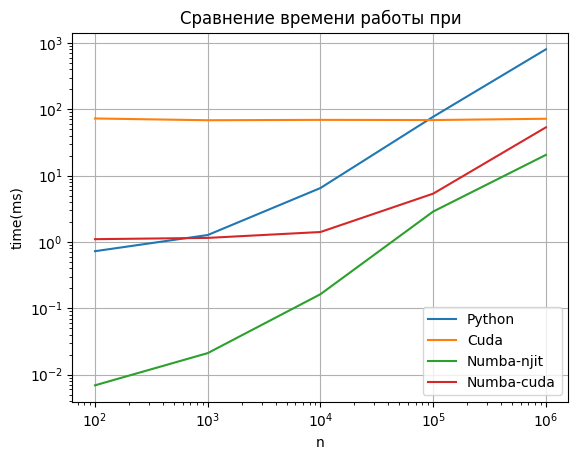

In [9]:
import matplotlib.pyplot as plt

python_times = [0.725, 1.27, 6.49, 77.0, 799.0]
cuda_times = [np.mean([80.853087, 66.343338, 83.481037, 65.937341, 65.842852]),
              np.mean([77.843041, 66.396017, 65.617729, 65.963939, 65.169027]),
              np.mean([66.523134, 73.504958, 65.686925, 68.464222, 71.369092]),
              np.mean([67.430058, 69.073217, 65.934651, 69.389626, 71.514924]),
              np.mean([67.917306, 84.503242, 68.994116, 72.131241, 65.425058])]
numba_times = [0.0069, 0.0211, 0.163, 2.87, 20.5]
numba_cuda_times = [1.1, 1.15, 1.41, 5.34, 53.3]

plt.plot(n, python_times)
plt.plot(n, cuda_times)
plt.plot(n, numba_times)
plt.plot(n, numba_cuda_times)
plt.title("Сравнение времени работы при")
plt.xlabel("n")
plt.ylabel("time(ms)")
plt.grid(True)
plt.legend(['Python', 'Cuda', 'Numba-njit', 'Numba-cuda'])
plt.xticks(n)
plt.xscale('log')
plt.yscale('log')

## Вывод
Используя библиотеку Numba, можно значительно ускорить вычисления за счет njit компиляции, даже не задействуя GPU.
Также для ускорения вычислений можно использовать декоратор cuda.jit, который компилирует код в машинный, для выполнения на GPU и позволяет управлять потоками, блоками и сетками для параллельного выполнения задач.